In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import ttest_ind
%matplotlib inline

# Introduction
**Can power demand be predicted?**

Power usage data from December 2006 to November 2010 was collected (single household outside of Paris) and here we see if there are any prominent insights we can deduce from the data. The original dataset listed both the date and time variables separately, so we will combine them and read the resulting timestamp in as a date object (which we index the data on).

The data can be found [here](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption).

## Motivation
Based on recent [statistics](https://www.statista.com/statistics/263424/the-largest-energy-utility-companies-worldwide-based-on-market-value/), the 2 largest electric utilities in France held a market value of 84.8 billion dollars, so a reduction of a little over 1% could save 1 billion dollars. There are two primary motivations that drive this analysis:
  * Customer: Do patterns exist in the data that can offer insight to the customer? Can we use this information to optimize how (and when) they consume power?
  * Utility: a primary benefit of forecasting demand is return on capital; if we can predict the demand we can better control the production of power.


In [3]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
df["Sub_metering_4"] = (df.Global_active_power*(1000/60)) - df.Sub_metering_1 - df.Sub_metering_2 - df.Sub_metering_3

## Variables

  * **sub_metering_1**: corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
  * **sub_metering_2**: corresponds to the laundry room, containing a washing-machine, a tumble drier, a refrigerator and a light. 
  * **sub_metering_3**: corresponds to an electric water-heater and an air-conditioner.
  * **sub_metering_4**: corresponds to all other electrical equipment.

In [60]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
Sub_metering_4           float64
dtypes: float64(8)
memory usage: 140.7 MB
None


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,9.314693e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,9.585916e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.036667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


Now that we have a brief overview of the structure of the data, let's take a quick look at how exactly one such reading is represented.

In [5]:
# get one day
sample_day = '2007-1-15'
sample = df[sample_day]
sample_hourly = sample.resample('H')
sample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
dt,,,,,,,,
2007-01-15 00:00:00,1.382,0.104,242.12,5.6,0.0,0.0,18.0,5.033333
2007-01-15 00:01:00,1.358,0.100,241.70,5.6,0.0,0.0,17.0,5.633333
2007-01-15 00:02:00,1.352,0.096,241.03,5.6,0.0,0.0,18.0,4.533333
2007-01-15 00:03:00,1.356,0.098,241.28,5.6,0.0,0.0,18.0,4.600000
2007-01-15 00:04:00,1.360,0.100,241.87,5.6,0.0,0.0,18.0,4.666667


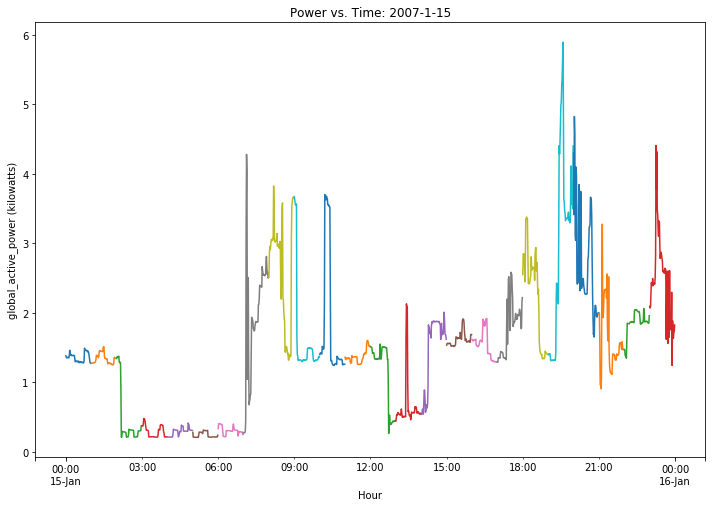

In [9]:
# simple time series plot of one day, by hour
plt.figure(figsize=(12,8))
sample_hourly.Global_active_power.plot()
plt.title("Power vs. Time: 2007-1-15")
plt.xlabel("Hour")
plt.ylabel("global_active_power (kilowatts)")
plt.show()

## Handling Missing Values
The dataset contains missing/null values in all of the columns (~1.25%), and we will just drop these rows for now.

In [3]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Sub_metering_4           25979
dtype: int64

In [4]:
df.dropna(inplace=True)
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Sub_metering_4           0
dtype: int64

## Statistical Features

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


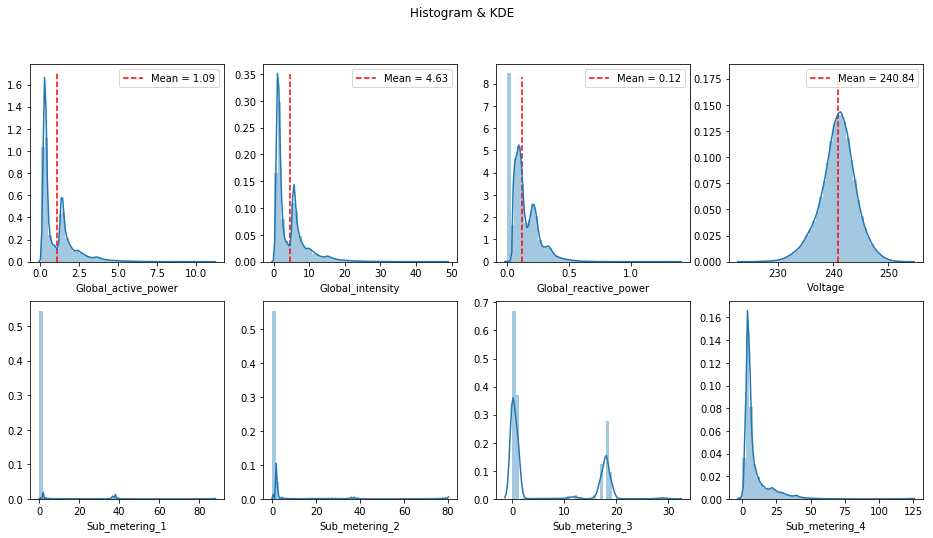

In [18]:
fig = plt.figure(figsize=(16,8))
fig.suptitle("Histogram & KDE")
plt.subplot(2,4,1)
sns.distplot(df.Global_active_power)
plt.vlines(df.Global_active_power.mean(), label="Mean = {}".format(round(df.Global_active_power.mean(),2)), ymin=0, ymax=1.7, linestyles="dashed", colors=["red"])
plt.legend()
plt.subplot(2,4,2)
sns.distplot(df.Global_intensity)
plt.vlines(df.Global_intensity.mean(), label="Mean = {}".format(round(df.Global_intensity.mean(),2)), ymin=0, ymax=0.35, linestyles="dashed", colors=["red"])
plt.legend()
plt.subplot(2,4,3)
sns.distplot(df.Global_reactive_power)
plt.vlines(df.Global_reactive_power.mean(), label="Mean = {}".format(round(df.Global_reactive_power.mean(),2)), ymin=0, ymax=8.3, linestyles="dashed", colors=["red"])
plt.legend()
plt.subplot(2,4,4)
sns.distplot(df.Voltage)
plt.vlines(df.Voltage.mean(), label="Mean = {}".format(round(df.Voltage.mean(),2)), ymin=0, ymax=0.18, linestyles="dashed", colors=["red"])
plt.legend()


plt.subplot(2,4,5)
sns.distplot(df.Sub_metering_1)
plt.subplot(2,4,6)
sns.distplot(df.Sub_metering_2)
plt.subplot(2,4,7)
sns.distplot(df.Sub_metering_3)
plt.subplot(2,4,8)
sns.distplot(df.Sub_metering_4)
plt.show()

The above histograms and KDE plots all show the inherent variability in the readings are quite high (with the exception of voltage). They also suggest the data follow a Poisson distribution, where the majority of readings are low but there are a smaller fraction that are quite high, leading to the high variability (and thus high standard deviation) in our features.

# Questions

As outlined in our motivations, we will attempt to address 3 main questions here:
  1. Identify patterns in customer power usage. What (if any) behavior changes can be suggested to increase efficiency for the customer?
  2. Can we build a predictive model to forecast demand?
  3. Is there anything interesting about the deviations from our forecasting model? 

## Weekdays vs. Weekends

It is reasonable to wonder if power usage differs significantly during the week compared to during the weekends. If in fact we do see a significant difference, this could be quite useful to the utility company when it comes to making scheduling decisions (demand). 

In [11]:
# first we need to resample our data, aggregating the values on a daily basis
df_days = df.resample('D').mean()
weekdays = df_days[df_days.index.dayofweek.isin([0,1,2,3,4])]
weekends = df_days[df_days.index.dayofweek.isin([5,6])]
# not sure why NA values are being introduced...
weekdays.dropna(inplace=True)
weekends.dropna(inplace=True)

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [111]:
spring = df[df.index.quarter==1].dropna()
summer = df[df.index.quarter==2].dropna()
autumn = df[df.index.quarter==3].dropna()
winter = df[df.index.quarter==4].dropna()

In [112]:
print(spring.Global_active_power.mean(),'\n',spring.Global_active_power.std())
print(summer.Global_active_power.mean(),'\n',summer.Global_active_power.std())
print(autumn.Global_active_power.mean(),'\n',autumn.Global_active_power.std())
print(winter.Global_active_power.mean(),'\n',winter.Global_active_power.std())

1.3318856166792654 
 1.1682651041923886
0.9958541336283255 
 0.9396917110447283
0.7475923617202975 
 0.8245022687644367
1.2981678205593752 
 1.150913204711231


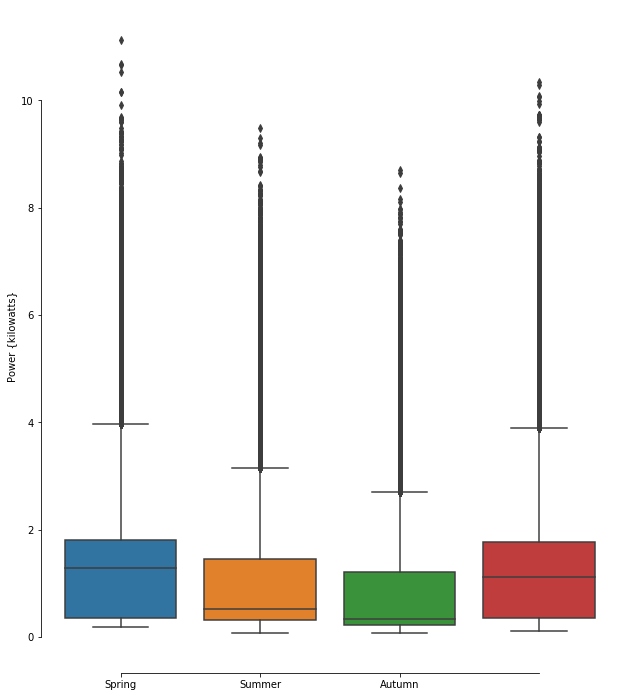

In [114]:
plt.figure(figsize=(10,12))
ax = sns.boxplot(x=df.index.quarter,y=df.Global_active_power)
sns.despine(offset=10, trim=True)
plt.ylabel("Power {kilowatts}")
plt.xlabel("")
plt.xticks(range(0,3), ["Spring","Summer","Autumn", "Winter"])
plt.show()

sns.

In [102]:
ttests = {"Global_active_power" : ttest_ind(weekdays.Global_active_power, weekends.Global_active_power, equal_var=False).pvalue,
          "Sub_metering_1" : ttest_ind(weekdays.Sub_metering_1, weekends.Sub_metering_1, equal_var=False).pvalue,
          "Sub_metering_2" : ttest_ind(weekdays.Sub_metering_2, weekends.Sub_metering_2, equal_var=False).pvalue,
          "Sub_metering_3" : ttest_ind(weekdays.Sub_metering_3, weekends.Sub_metering_3, equal_var=False).pvalue,
          "Sub_metering_4" : ttest_ind(weekdays.Sub_metering_4, weekends.Sub_metering_4, equal_var=False).pvalue
         }
print(ttests)

{'Global_active_power': 5.7736192508333766e-12, 'Sub_metering_1': 4.3499985516699334e-27, 'Sub_metering_2': 1.8217270312804771e-09, 'Sub_metering_3': 0.05663256526077492, 'Sub_metering_4': 2.1940495668929437e-07}


Text(0.5, 1.0, 'Weekends')

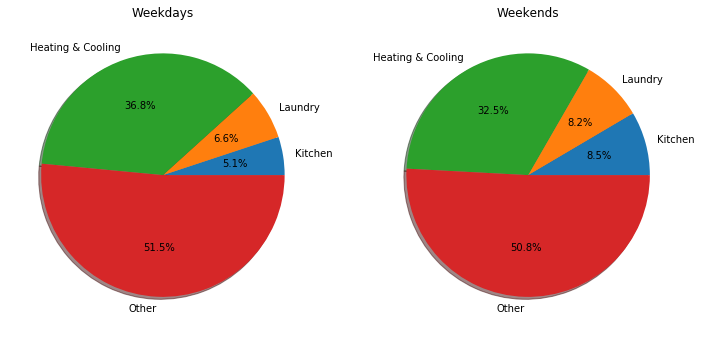

In [116]:
labels = ["Kitchen", "Laundry", "Heating & Cooling", "Other"]
ratios_weekdays = [weekdays.Sub_metering_1.mean(), 
                   weekdays.Sub_metering_2.mean(),
                   weekdays.Sub_metering_3.mean(),
                   weekdays.Sub_metering_4.mean()
                  ]
ratios_weekends = [weekends.Sub_metering_1.mean(), 
                   weekends.Sub_metering_2.mean(), 
                   weekends.Sub_metering_3.mean(), 
                   weekends.Sub_metering_4.mean()]
# The total power is = to Global_active_power.mean()*1000/60
# so multiply the means by (100/6) to get the percent of total power
ratios_weekdays = np.divide(ratios_weekdays, (100/6)*weekdays.Global_active_power.mean())

ratios_weekends = np.divide(ratios_weekends, (100/6)*weekends.Global_active_power.mean())

fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pie(ratios_weekdays, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title("Weekdays")
plt.subplot(1,2,2)
plt.pie(ratios_weekends, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title("Weekends")

In [119]:
print(ttests,'\n')
print(ttest_ind(weekdays.Global_active_power, weekends.Global_active_power, equal_var=False))

{'Global_active_power': 5.7736192508333766e-12, 'Sub_metering_1': 4.3499985516699334e-27, 'Sub_metering_2': 1.8217270312804771e-09, 'Sub_metering_3': 0.05663256526077492, 'Sub_metering_4': 2.1940495668929437e-07} 

Ttest_indResult(statistic=-7.030997538163633, pvalue=5.7736192508333766e-12)


The pie charts above suggest a significant change in sub-metering 1,2 and 3 but not really for other. However, according to the T-Tests we performed there we can conclude that there a statistical significance in weekend vs. weekday usage for kitchen, laundry and other electrical equipment, but not in heating & cooling usage.

## Hourly
Similarly to accounting for differences during the week, it is also reasonable to wonder if power consumption varies hourly. 

In [120]:
hourly = df.groupby(df.index.hour).mean()
weekday = df.groupby(df.index.weekday).mean()
weekly = df.groupby(df.index.weekofyear).mean()
quarterly = df.groupby(df.index.quarter).mean()

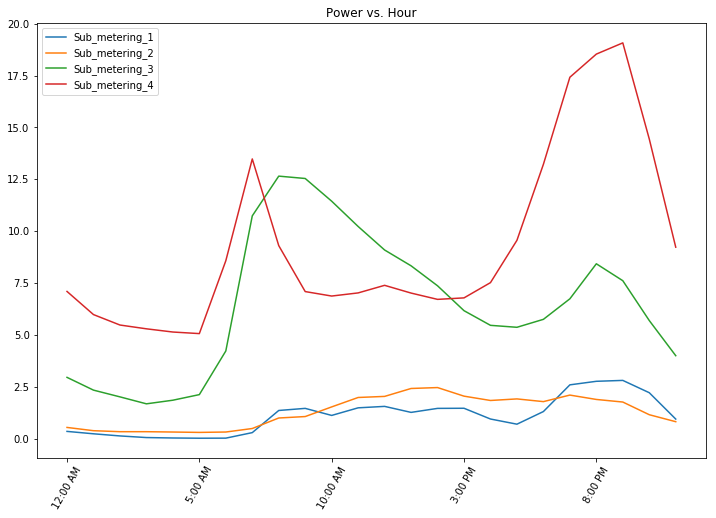

In [121]:
plt.figure(figsize=(12,8))
plt.plot(hourly.Sub_metering_1)
plt.plot(hourly.Sub_metering_2)
plt.plot(hourly.Sub_metering_3)
plt.plot(hourly.Sub_metering_4)
plt.title("Power vs. Hour")
plt.legend()
times = ["12:00 AM", "5:00 AM", "10:00 AM", "3:00 PM", "8:00 PM"]
plt.xticks(range(0,24, 5), times, rotation=60)
plt.show()

There are a few behavior changes we can suggest from this plot:
  * A significant amount of power is consumed for heating & cooling purposes, replacing active sources (like central heating, AC) with more passive devices (fans or wood stove)
  * Sub-metering 4 (other) constitutes a lot of total power consumption which suggests that reducing/eliminating certain equipment that falls in this category will dramatically reduce total power consumption. 
  * The time of day that other equipment peak coincide with highs in heating & cooling in the morning (between 6-7 AM) and again in the evening (5-7 PM), which leads me to suspect usage of equipment like a coffee machine, microwave or toaster oven. Replacing these devices with more energy efficient equipment could drastically decrease power consumption. 

## Forecasting

As previously stated, large amounts of capital are invested in the energy sector every year, and so if we can develop a model to predict demand, we could offer substantial savings to utilities. We will predict the 
On top of providing customers with insights into their own power usage, it could be just as, if not more valuable to the utility company to be able to forecast energy demand. A simple, predictive model will be constructed only using the moving-average of the previous n periods (7 for daily, 12 for monthly).

In [122]:
def compute_rolling_averages(observed, window_length):
    # want to return the predictions (moving-averages)
    # and the deviations from this
    rolling = observed.rolling(window_length, center = True).mean()
    rolling_deviations = observed.rolling(window_length, center = True).std()
    deviations = np.subtract(observed, rolling)
    return rolling, rolling_deviations, deviations

In [123]:
window_days = 7
window_month = 12
observed_days = df.resample('D').mean()
observed_months = df.resample('M').mean()
y_days, y_days_std, y_days_devs = compute_rolling_averages(observed_days, window_days)
y_months, y_months_std, y_months_devs = compute_rolling_averages(observed_months, window_month)
y_months6, y_months_std6, y_months_devs6 = compute_rolling_averages(observed_months, 6)

### Deviations

As mentioned above, the energy market in France is worth a lot of money so if we can reduce variability in our predictions this model could be quite valuable to utility companies. Therefore, let's take a closer look at how the differences (deviations) between our predictions and observed values are distributed.  

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


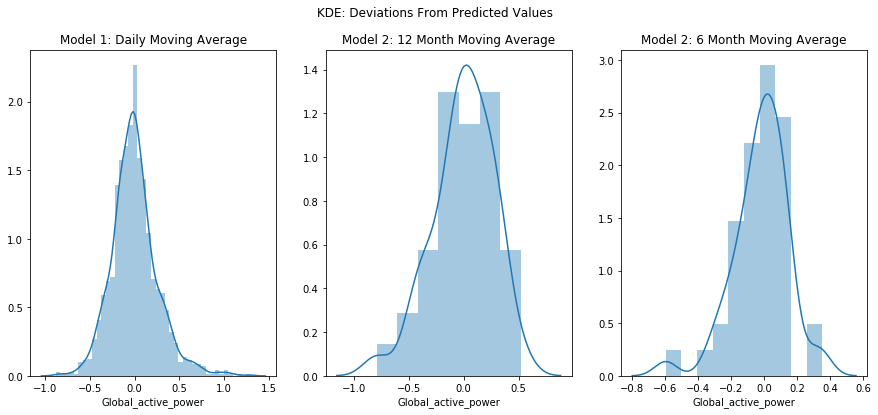

In [124]:
fig = plt.figure(figsize=(15,6))
fig.suptitle("KDE: Deviations From Predicted Values")
plt.tight_layout()
plt.subplot(1,3,1)
sns.distplot(y_days_devs.Global_active_power.dropna())
plt.title("Model 1: Daily Moving Average")
plt.subplot(1,3,2)
sns.distplot(y_months_devs.Global_active_power.dropna())
plt.title("Model 2: 12 Month Moving Average")
plt.subplot(1,3,3)
sns.distplot(y_months_devs6.Global_active_power.dropna())
plt.title("Model 2: 6 Month Moving Average")
plt.show()

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


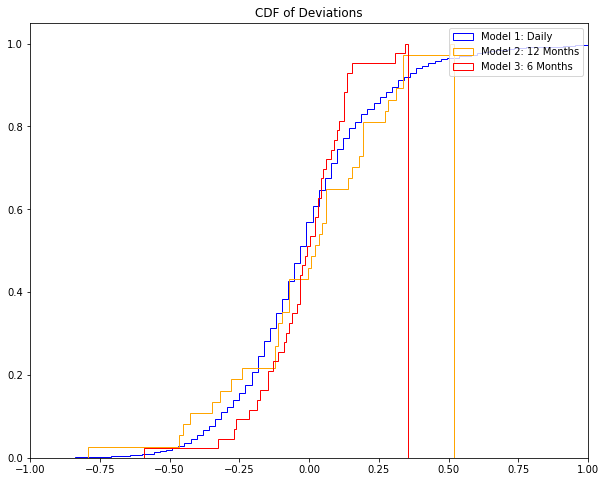

In [125]:
plt.figure(figsize=(10,8))
plt.title("CDF of Deviations")
plt.hist(y_days_devs.Global_active_power, histtype='step', cumulative=True, density=True, 
         bins=100, stacked=True, label="Model 1: Daily", color="blue")
plt.hist(y_months_devs.Global_active_power, histtype='step', cumulative=True, density=True, 
         bins=100, stacked=True, color="orange", label="Model 2: 12 Months")
plt.hist(y_months_devs6.Global_active_power, histtype='step', cumulative=True, 
         density=True, bins=100, stacked=True, color="red", label="Model 3: 6 Months")
plt.xlim(-1,1)
plt.legend()
plt.show()

In [126]:
print(sum(y_days_devs.Global_active_power.between(-0.25,0.25)) / len(y_days_devs.Global_active_power))
print(sum(y_months_devs.Global_active_power.between(-0.25,0.25)) / len(y_months_devs.Global_active_power))
print(sum(y_months_devs6.Global_active_power.between(-0.25,0.25)) / len(y_months_devs6.Global_active_power))

0.694868238557559
0.4791666666666667
0.7708333333333334


Ideally there would be no difference in the predicted and observed values, however a perfect model does not exist so we want our deviations to be centered near 0, with very little variability (see KDE plots). We can also use the cumulative distribution function plots to identify the preferable model. It is clear that model 3 has the least variation, with over 77% of all predictions being within 0.25 kilowatts of actual power consumed (versus 69% for model 1 and 48% for model 2).  

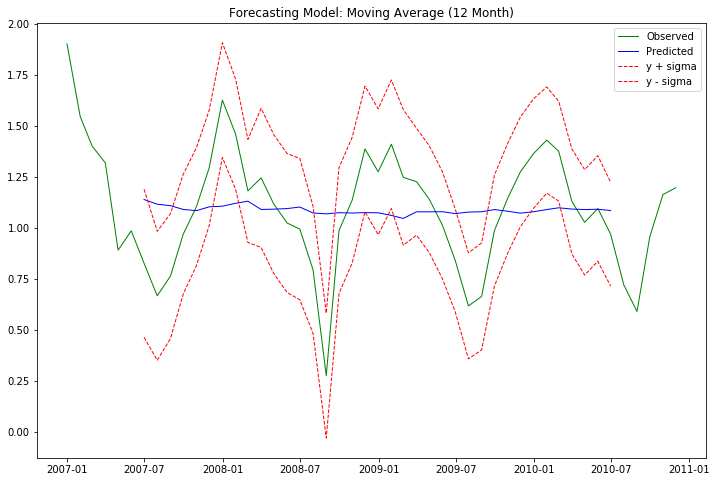

In [127]:
plt.figure(figsize=(12,8))
plt.title("Forecasting Model: Moving Average (12 Month)")
plt.plot(observed_months.Global_active_power, 
         color = "green", 
         label="Observed", 
         linewidth=1)
plt.plot(y_months.Global_active_power, 
         color="blue", 
         label="Predicted", 
         linewidth=1)
plt.plot(np.add(observed_months.Global_active_power, 
                y_months_std.Global_active_power), 
         linestyle="--", 
         color="red", 
         label="y + sigma", 
         linewidth=1)
plt.plot(np.subtract(observed_months.Global_active_power, 
                     y_months_std.Global_active_power), 
         linestyle="--", 
         color="red", 
         label="y - sigma", 
         linewidth=1)
plt.legend()
plt.show()

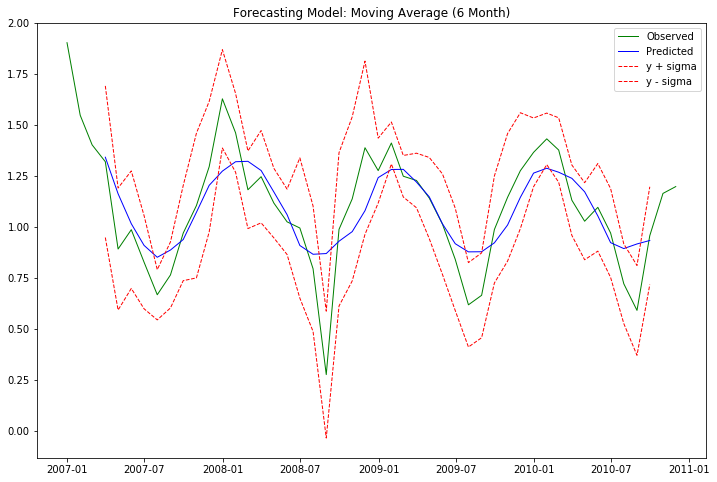

In [185]:
plt.figure(figsize=(12,8))
plt.title("Forecasting Model: Moving Average (6 Month)")
plt.plot(observed_months.Global_active_power, 
         color = "green", 
         label="Observed", 
         linewidth=1)
plt.plot(y_months6.Global_active_power, 
         color="blue", 
         label="Predicted", 
         linewidth=1)
plt.plot(np.add(observed_months.Global_active_power, 
                y_months_std6.Global_active_power), 
         linestyle="--", 
         color="red", 
         label="y + sigma", 
         linewidth=1)
plt.plot(np.subtract(observed_months.Global_active_power, 
                     y_months_std6.Global_active_power), 
         linestyle="--", 
         color="red", 
         label="y - sigma", 
         linewidth=1)
plt.legend()
plt.show()

In [128]:
# generate model statistics
# R-Squared
SS_Residual_days = np.sum((np.subtract(y_days.Global_active_power, 
                                       observed_days.Global_active_power)**2))
SS_Total_days = np.sum((np.subtract(observed_days.Global_active_power, 
                                    observed_days.Global_active_power.mean())**2))

SS_Residual_months = np.sum((np.subtract(y_months.Global_active_power,
                                          observed_months.Global_active_power)**2))
SS_Total_months = np.sum((np.subtract(observed_months.Global_active_power,
                                     observed_months.Global_active_power.mean())**2))
SS_Residual_months_6 = np.sum(np.subtract(y_months6.Global_active_power,
                                         observed_months.Global_active_power)**2)
SS_Total_months_6 = np.sum((np.subtract(observed_months.Global_active_power,
                                       observed_months.Global_active_power.mean())**2))
R_Squared_days = 1 - SS_Residual_days / SS_Total_days
R_Squared_months = 1 - SS_Residual_months / SS_Total_months
R_Squared_months_6 = 1 - SS_Residual_months_6 / SS_Total_months_6

In [130]:
# MSE
MSE_days = np.sum((np.subtract(y_days.Global_active_power, 
                               observed_days.Global_active_power)**2)) / len(observed_days)
MSE_months = np.sum((np.subtract(y_months.Global_active_power, 
                                 observed_months.Global_active_power)**2) / len(observed_months.Global_active_power))
MSE_months_6 = np.sum((np.subtract(y_months6.Global_active_power, 
                                 observed_months.Global_active_power)**2) / len(observed_months.Global_active_power))

In [131]:
print("R-Squared Values\n===============================\n")
print("Model 1 (7 Days): {}\nModel 2 (12 Months): {}\nModel 3 (6 Months): {}\n".format(R_Squared_days, R_Squared_months, R_Squared_months_6))
print("MSE Values\n=======================\n")
print("Model 1 (7 Days): {}\nModel 2 (12 Months): {}\nModel 3 (6 Months): {}".format(MSE_days, MSE_months, MSE_months_6))

R-Squared Values

Model 1 (7 Days): 0.6291906835396923
Model 2 (12 Months): 0.351335005256063
Model 3 (6 Months): 0.7172402005573617

MSE Values

Model 1 (7 Days): 0.06508572539157902
Model 2 (12 Months): 0.056874479444716464
Model 3 (6 Months): 0.024792175516640667


In [145]:
avg_error_days = y_days_devs.Global_active_power.mean() / y_days.Global_active_power.mean()
avg_error_months_6 = y_months_devs.Global_active_power.mean() / y_months.Global_active_power.mean()
avg_error_months_12 = y_months_devs6.Global_active_power.mean() / y_months6.Global_active_power.mean()

print("Average Deviations by Model\n\n")
print("Model 1 (daily): {} %".format(np.abs(round(100*avg_error_days,4))))
print("Model 2 (6 months): {} %".format(np.abs(round(100*avg_error_months_6, 4))))
print("Model 3 (12 months): {} %".format(np.abs(round(100*avg_error_months_12, 4))))

Average Deviations by Model


Model 1 (daily): 0.0559 %
Model 2 (6 months): 0.4324 %
Model 3 (12 months): 1.5913 %


### Model Selection
Based on the R-Squared and MSE values reported above (where we prefer larger R-Squared values and lower MSE values) model 3 is the best of these 3 models. In all 3 of our models, we slightly overestimate the power usage.

# Conclusions
The readings appear to follow a Poisson distribution, with a large amount of them falling in the lower 50%, histograms appear to reveal a bimodal behavior – possibly conditioned on time of the day. This inherent variability in the data will lead to limitations in forecasting, unless other factors are also considered. 

Using visual and statistical techniques, I was able to deduce certain patterns in power consumption for this particular household: there is a noticeable change in power consumption from the week to weekends, especially in kitchen and laundry equipment while heating and cooling usage remained constant throughout the week. With heating & cooling usage remaining relatively constant throughout the week and the fact that it accounts for over 30% of total power use it would be preferable to decrease this. Since sub-metering 4 does not explicitly declare what equipment falls in this category and the fact that this equipment accounts for over 50% of power it could be very valuable to identify the primary sources that contribute here. 

Forecasting can be extremely valuable, and here we built a very simple model that simply predicted the power consumption using only the moving-average from previous data (recent). We built three models, one using daily data (7 days), one using 12 months and the other 6 months. One noticeable trait of our model (monthly) is that it can predict the output (within one standard deviation) on all days with the exception of 3 time periods where power hit an extreme low or high. The observed data appears to follow a wave function, possibly indicating that power usage follows a cyclical trend like weather. We used the MSE as the loss function, and showed that decreasing the window size resulted in a lower loss and higher R-Squared value. 